In [1]:
import datetime as dt
import math

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

import sys

sys.path.append("..")
# from tooling.enums import AssetClass, Index, Spot, StrikeSpread
# from tooling.fetch import fetch_option_data, fetch_spot_data
# from tooling.filter import find_atm, option_tool

from fetching_from_local_db.enums import AssetClass, Index, StrikeSpread
from fetching_from_local_db.fetch_from_db import (
    _fetch_batch,
    fetch_data,
    fetch_spot_data,
)

In [2]:
async def get_expiry(f_today):

    if (f_today <= dt.date(2024, 1, 25)) and (f_today >= dt.date(2024, 1, 18)):
        f_expiry = dt.date(2024, 1, 25)
    elif (f_today <= dt.date(2024, 1, 31)) and (f_today >= dt.date(2024, 1, 26)):
        f_expiry = dt.date(2024, 1, 31)
    elif (f_today <= dt.date(2024, 2, 22)) and (f_today >= dt.date(2024, 2, 29)):
        f_expiry = dt.date(2024, 2, 29)
    elif (f_today <= dt.date(2024, 3, 25)) and (f_today >= dt.date(2024, 3, 27)):
        f_expiry = dt.date(2024, 2, 27)
    elif f_today < dt.date(2023, 9, 1):
        days_to_thursday = (3 - f_today.weekday()) % 7
        nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
        f_expiry = nearest_thursday
        if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
            f_expiry = nearest_thursday - dt.timedelta(days=1)
    elif f_today >= dt.date(2023, 9, 1):
        if f_today.day < 24:
            days_to_wednesday = (2 - f_today.weekday()) % 7
            nearest_wednesday = f_today + dt.timedelta(days=days_to_wednesday)
            f_expiry = nearest_wednesday
            if nse.valid_days(
                start_date=nearest_wednesday, end_date=nearest_wednesday
            ).empty:
                f_expiry = nearest_wednesday - dt.timedelta(days=1)
        else:
            days_to_thursday = (3 - f_today.weekday()) % 7
            nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
            f_expiry = nearest_thursday
            if nse.valid_days(
                start_date=nearest_thursday, end_date=nearest_thursday
            ).empty:
                f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_finnifty(f_today):

    days_to_thursday = (1 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_nifty(f_today):

    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_midcpnifty(f_today):

    days_to_thursday = (0 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


import datetime as dt


async def get_monthly_expiry_nifty(input_date):
    # Get the last day of the current month
    current_month_last_day = (
        input_date.replace(day=28) + dt.timedelta(days=4)
    ).replace(day=1) - dt.timedelta(days=1)

    # Find the last Thursday of the current month
    last_thursday_current_month = current_month_last_day - dt.timedelta(
        days=(current_month_last_day.weekday() - 3) % 7
    )

    # Check if the current date is less than the last Thursday of the current month
    if input_date < last_thursday_current_month:
        last_thursday = last_thursday_current_month
    else:
        # If the current date has passed the last Thursday, find the last Thursday of the next month
        next_month = (input_date.month % 12) + 1
        next_month_year = input_date.year if next_month > 1 else input_date.year + 1

        # Get the last day of the next month (considering February correctly)
        if next_month == 2:  # February
            if next_month_year % 4 == 0 and (
                next_month_year % 100 != 0 or next_month_year % 400 == 0
            ):
                last_day_of_next_month = 29  # Leap year
            else:
                last_day_of_next_month = 28  # Non-leap year
        else:
            # Calculate the last day of the next month
            last_day_of_next_month = (
                dt.date(next_month_year, next_month, 1) + dt.timedelta(days=31)
            ).replace(day=1) - dt.timedelta(days=1)
            last_day_of_next_month = (
                last_day_of_next_month.day
            )  # Extract the day as an integer

        # Create a date for the last day of the next month
        last_day_of_next_month_date = dt.date(
            next_month_year, next_month, last_day_of_next_month
        )

        # Find the last Thursday of the next month
        last_thursday = last_day_of_next_month_date - dt.timedelta(
            days=(last_day_of_next_month_date.weekday() - 3) % 7
        )

    # Validate if the last Thursday is a trading day
    if nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
        # If it's a holiday, find the previous valid trading day
        last_thursday -= dt.timedelta(days=1)
        while nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
            last_thursday -= dt.timedelta(days=1)

    return last_thursday


async def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [3]:
# bnf_pandas = pd.read_csv("../data/bnf_min.csv")
bnf_pandas = pd.read_csv("../data/nifty.csv")
# bnf_pandas = pd.read_csv("../data/fin_min.csv")
# bnf_pandas = pd.read_csv("../data/midcp_min.csv")
# bnf_pandas = pd.read_csv("../data/sensex_min.csv")
# bnf_pandas = pd.read_csv("../data/bankex_min.csv")

In [4]:
# If Stocks Data ...
bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["datetime"])
bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# bnf_pandas

In [5]:
bnf = pl.DataFrame(bnf_pandas)
print(type(bnf))
# bnf

<class 'polars.dataframe.frame.DataFrame'>


In [6]:
bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")
bnf = bnf.with_columns(pl.col("index").alias("datetime"))

In [7]:
# bnf = bnf.rename({"open": "o", "high": "h", "low": "l", "close": "c", "volume": "v"})

In [300]:
def resample(data, timeframe, offset=None):
    agg_list = [
        pl.col("o").first().alias("o"),
        pl.col("h").max().alias("h"),
        pl.col("l").min().alias("l"),
        pl.col("c").last().alias("c"),
    ]
    if timeframe == '10m':
        offset = '5m'
    if "v" in data.columns:
        agg_list.append(pl.col("v").sum().alias("v"))
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(agg_list)
    )


In [9]:
# def generate_signals(df, n=5):
#     import numpy as np
#     import pandas as pd

#     # Ensure required columns are present
#     required_cols = {'o', 'h', 'l', 'c', 'datetime'}
#     if not required_cols.issubset(df.columns):
#         raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
#     # Ensure datetime is in datetime format
#     if not np.issubdtype(df['datetime'].dtype, np.datetime64):
#         df['datetime'] = pd.to_datetime(df['datetime'])
    
#     # Calculate the low of the previous n candles
#     df['Prev_N_Low'] = df['l'].rolling(window=n).min().shift(1)
    
#     # Generate sell signal
#     df['Sell Signal'] = df['c'] < df['Prev_N_Low']
    
#     # Drop intermediate columns if not needed
#     df.drop(columns=['Prev_N_Low'], inplace=True, errors='ignore')
    
#     return df


In [12]:
!poetry add pandas-ta

The following packages are already present in the pyproject.toml and will be skipped:

  • pandas-ta

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [367]:
def generate_signals(df, st_num=3, ema=5, pct=0.9):
    """
    Calculate signals for reversal selling strategy.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with columns 'datetime', 'o', 'h', 'l', 'c', and optionally 'v'.
    
    Returns:
    pd.DataFrame: DataFrame with additional columns 'Reversal Sell Signal' and tracking indicators.
    """
    # Ensure the DataFrame has the required columns
    required_columns = {'datetime', 'h', 'l', 'c'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Calculate a 3-period high (short-term high)
    df['short_term_low'] = df['l'].rolling(window=st_num).min().shift(1)

    # Calculate a very short-term EMA (e.g., 5-period)
    df['EMA_5'] = df['c'].ewm(span=ema, adjust=False).mean()
    
    # Calculate daily high till now
    df['daily_high_till_now'] = df.groupby(df['datetime'].dt.date)['h'].cummax()
    
    # Define Reversal Sell Signal
    # df['Sell Signal'] = (
    #     (df['h'] > (pct*df['daily_high_till_now'].shift(1))) &  # Price is near or above the daily high
    #     (df['c'] < df['short_term_low']) &  # Closing below the short-term high (early weakness)
    #     (df['c'] < df['EMA_5'])  # Close below very short-term EMA for confirmation
    # ).astype(int)
    df['Sell Signal'] = (
        (df['h'] > (pct*df['daily_high_till_now'].shift(1))) &  # Price is near or above the daily high
        (df['c'] < df['short_term_low'])).astype(int)
    
    return df


In [368]:
data = bnf_pandas.copy()
# data['datetime'] = pd.to_datetime(data['datetime'].dt.date)
print(data["datetime"].tail())
trading_days_set = set(data["datetime"].dt.date)
# sorted(trading_days_set)

735722   2024-12-13 15:25:00
735723   2024-12-13 15:26:00
735724   2024-12-13 15:27:00
735725   2024-12-13 15:28:00
735726   2024-12-13 15:29:00
Name: datetime, dtype: datetime64[ns]


In [380]:
# GLOBAL VARIABLES

INSTRUMENT = "NIFTY"
INDEX = "nifty"
INDEX_MROUND = 50
# INDEX_MROUND=100

# INSTRUMENT = "NIFTY"
# INDEX = "nifty"
# INDEX_MROUND=50

PORTFOLIO_VALUE = 10_00_000
INDEX_LEV = 8
RPT_CE = 0.01
RPT_PE = 0.01
SLIPPAGE = 0.01
TF = "5m"

# SIGNAL_MA = 20
# NUM_OF_CANDELS = 1
# T_MA=20
# TARGET=100

In [381]:
bnf = resample(bnf, TF)
data = bnf.to_pandas()
data.tail()
# data[['MA','signal_spot']]=MA(data,200)
# data[data['signal_spot']==1].head(50)
# bnf
# data.tail(50)
# data[data['datetime'].dt.date == dt.date(2024, 4, 29)]

,datetime,o,h,l,c
74556,2024-12-13 14:40:00,24738.7500,24738.7500,24705.8500,24733.2500
74557,2024-12-13 14:50:00,24728.6000,24748.8500,24728.0000,24745.1500
74558,2024-12-13 15:00:00,24744.8500,24790.2500,24735.9000,24771.4500
74559,2024-12-13 15:10:00,24772.1500,24792.3000,24761.0500,24790.0500
74560,2024-12-13 15:20:00,24790.9000,24790.9000,24778.8500,24781.3000


In [428]:
async def ce_trade(data, st_high, ema, pct):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    ce_lowest_low = float("inf")
    ce_highest_high = float("-inf")
    entry_rsi = 0

    while current_date < end_date:
        # print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_ce_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_ce_sl = False
        previous_ce_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_ce_trade and current_date in trading_days_set:

            ce_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {ce_search_datetime}')

            spot_open = df.loc[df["datetime"] >= ce_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.ceil(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_ce = spot_atm
            # print(f'selected strike CE : {selected_strike_ce}')
            ce_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=7),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_ce,
                asset_class="C",
                expiry=nearest_expiry,
            )
            # print(ce_df)
            if ce_df is not None and not isinstance(ce_df, str):
                # print('new data fetched CE')
                data_ce = True
                ce_df = ce_df.select(["datetime", "o", "h", "l", "c", "v"])
                ce_df = resample(ce_df, TF)
                ce_df_pandas = ce_df.to_pandas()
                ce_df = generate_signals(ce_df_pandas, st_high, ema, pct)
                # ce_df = calculate_signals(ce_df_pandas)
                # print(ce_df.to_string())
            else:
                data_ce = False
                current_date += dt.timedelta(days=1)
                continue

            if data_ce:

                for i in range(0, len(ce_df)):
                    current_candle = ce_df.iloc[i]
                    current_candle_open = ce_df.iloc[i]["o"]
                    current_candle_high = ce_df.iloc[i]["h"]
                    current_candle_low = ce_df.iloc[i]["l"]
                    current_candle_close = ce_df.iloc[i]["c"]

                    previous_candle_low = ce_df.iloc[i - 1]["l"]
                    previous_candle_close = ce_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_ce
                    asset_class = "C"
                    # print(ce_df.iloc[i])

                    signal = ce_df.iloc[i - 1]["Sell Signal"]

                    if ce_df.iloc[i]["datetime"] >= ce_search_datetime:


                        if (
                            not previous_ce_sl_hit
                            and not in_ce_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and ce_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - ce_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - ce_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and ce_df.iloc[i]["datetime"].time() < dt.time(15, 25)
                        ):
                            # print(ce_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {ce_df.iloc[i]["datetime"]}')
                            
                            # today_data = ce_df[ce_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i-1]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = ce_df.iloc[i-1]["datetime"].date()
                            entry_time = ce_df.iloc[i-1]["datetime"].time()
                            # initial_sl = ce_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = ce_df.iloc[i-1]['daily_high_till_now']
                            in_ce_trade = True
                            ce_lowest_low = float("inf")
                            ce_highest_high = float("-inf")
                            # print(f'initial SL : {initial_sl}')
                            # entry_rsi = ce_df.iloc[i-1]['RSI']

                            qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                            # print(f'qty : {qty}')

                        # While in trade, track the highest high and lowest low
                        if in_ce_trade:
                            # Track the highest high
                            ce_highest_high = max(ce_highest_high, current_candle_high)

                            # Track the lowest low
                            ce_lowest_low = min(ce_lowest_low, current_candle_low)

                            # if all(
                            #     ce_df.loc[i - j, "h"] <= ce_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = ce_df.loc[i - fractal_num, "h"]

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(ce_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_ce_trade and current_candle_high > initial_sl:
                            # print(ce_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].date() == nearest_expiry
                            and ce_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(ce_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_ce_trade
                            and not previous_ce_sl_hit
                            and ce_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [436]:
async def pe_trade(data, st_high, ema, pct):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    pe_lowest_low = float("inf")
    pe_highest_high = float("-inf")
    entry_rsi = 0

    while current_date < end_date:
        # print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_pe_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_pe_sl = False
        previous_pe_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_pe_trade and current_date in trading_days_set:

            pe_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {pe_search_datetime}')

            spot_open = df.loc[df["datetime"] >= pe_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.floor(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_pe = spot_atm
            # print(f'selected strike PE : {selected_strike_pe}')
            pe_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=7),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_pe,
                asset_class="P",
                expiry=nearest_expiry,
            )
            if pe_df is not None and not isinstance(pe_df, str):
                # print('new data fetched PE')
                data_pe = True
                pe_df = pe_df.select(["datetime", "o", "h", "l", "c", "v"])
                pe_df = resample(pe_df, TF)
                pe_df_pandas = pe_df.to_pandas()
                pe_df = generate_signals(pe_df_pandas, st_high, ema, pct)
                # pe_df = calculate_signals(pe_df_pandas)
                # print(pe_df.to_string())
            else:
                data_pe = False
                current_date += dt.timedelta(days=1)
                continue

            if data_pe:

                for i in range(0, len(pe_df)):
                    current_candle = pe_df.iloc[i]
                    current_candle_open = pe_df.iloc[i]["o"]
                    current_candle_high = pe_df.iloc[i]["h"]
                    current_candle_low = pe_df.iloc[i]["l"]
                    current_candle_close = pe_df.iloc[i]["c"]

                    previous_candle_low = pe_df.iloc[i - 1]["l"]
                    previous_candle_close = pe_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_pe
                    asset_class = "P"
                    # print(pe_df.iloc[i])

                    signal = pe_df.iloc[i - 1]["Sell Signal"]

                    if pe_df.iloc[i]["datetime"] >= pe_search_datetime:


                        if (
                            not previous_pe_sl_hit
                            and not in_pe_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and pe_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - pe_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - pe_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and pe_df.iloc[i]["datetime"].time() < dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {pe_df.iloc[i]["datetime"]}')
                            
                            # today_data = pe_df[pe_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = pe_df.iloc[i-1]["datetime"].date()
                            entry_time = pe_df.iloc[i-1]["datetime"].time()
                            # initial_sl = pe_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = pe_df.iloc[i-1]['daily_high_till_now']
                            in_pe_trade = True
                            pe_lowest_low = float("inf")
                            pe_highest_high = float("-inf")
                            # entry_rsi = pe_df.iloc[i-1]['RSI']

                            qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                        # While in trade, track the highest high and lowest low
                        if in_pe_trade:
                            # Track the highest high
                            pe_highest_high = max(pe_highest_high, current_candle_high)

                            # Track the lowest low
                            pe_lowest_low = min(pe_lowest_low, current_candle_low)

                            # if all(
                            #     pe_df.loc[i - j, "h"] <= pe_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = pe_df.loc[i - fractal_num, "h"]

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(pe_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_pe_trade and current_candle_high > initial_sl:
                            # print(pe_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        # if in_pe_trade and (current_candle_close > tsl_high) and (tsl_high > 10):
                        #     # print(pe_df.iloc[i])
                        #     # print(f'initial sl hit {initial_sl}')
                        #     # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                        #     exit=current_candle_close
                        #     otm_datetime = pe_df.iloc[i]['datetime']
                        #     in_pe_trade=False
                        #     stop_trading=False
                        #     previous_pe_sl_hit=True
                        #     is_gap_pe_sl = False
                        #     points_captured=entry-exit
                        #     exit_time = pe_df.iloc[i]['datetime'].time()
                        #     slippage= SLIPPAGE * (entry+exit)
                        #     pnl=(qty*(points_captured-slippage))
                        #     # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                        #     remark = "TSL hit"
                        #     weekday_int = entry_date.weekday()
                        #     weekday_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][weekday_int]
                        #     trade = {
                        #             'date' : entry_date,
                        #             'day' : weekday_name,
                        #             'expiry' : expiry,
                        #             'DTE' : (nearest_expiry-entry_date).days,
                        #             # 'atm' : atm,
                        #             # 'scrip' : index ,
                        #             'strike' : strike,
                        #             'type' : asset_class,
                        #             'Entry Price': entry,
                        #             'Entry Time': entry_time,
                        #             'initial sl' : initial_sl,
                        #             'TSL' : tsl_high,
                        #             # 'OTM Entry' : otm_entry,
                        #             'Exit Price': exit,
                        #             'Exit date' : pe_df.iloc[i]['datetime'].date(),
                        #             'Exit Time': exit_time,
                        #             # 'OTM EXIT ' : otm_exit,
                        #             'Remark' : remark,
                        #             'Points Captured': points_captured,
                        #             'Slippage': slippage,
                        #             # 'OTM cost' : otm_exit-otm_entry,
                        #             'Qty': qty,
                        #             'PnL' : pnl,
                        #             'ROI%': (pnl/ PORTFOLIO_VALUE) * 100,
                        #             'Trade Year': pe_df.iloc[i]['datetime'].year,
                        #             'Trade Month': pe_df.iloc[i]['datetime'].month,
                        #             'Highest High': pe_highest_high,  # Add highest high to trade data
                        #             'Lowest Low': pe_lowest_low ,      # Add lowest low to trade data
                        #             'Max ROI%' : ((qty*(entry-pe_lowest_low))/PORTFOLIO_VALUE)*100,
                        #             'Margin' : ((qty*strike)/(INDEX_LEV*PORTFOLIO_VALUE))*100
                        #               }
                        #     # print('apending initial sl trade')
                        #     trade_book.append(trade)
                        #     tsl_high = 0
                        #     points_captured=0
                        #     current_date = pe_df.iloc[i]['datetime'].date()
                        #     current_date_increament_flag = True
                        #     time_of_day = pe_df.iloc[i]['datetime'].time()
                        #     # print(f'current date changed to : {current_date} and time to {time_of_day}')
                        #     break

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].date() == nearest_expiry
                            and pe_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_pe_trade
                            and not previous_pe_sl_hit
                            and pe_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [437]:
async def execute(DF, n, rsi_n, rsi_overbought):
    data = DF.copy()
    tb_ce = await ce_trade(data, n, rsi_n, rsi_overbought)
    tb_pe = await pe_trade(data, n, rsi_n, rsi_overbought)
    tb = pd.concat([tb_ce, tb_pe], ignore_index=True)
    # print(len(tb))
    if len(tb)>0:
        tb = tb.sort_values(by="date")
    return tb

In [438]:
def generate_stats(tb_expiry, ema_window):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe

    # Iterate over each year
    for year in range(2019, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()

        # Calculate total number of trades
        total_trades = len(year_trades)

        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100

        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()

        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f"{ema_window}"

        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]

    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0][
        "ROI%"
    ].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum()
        - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio: stats_df8}

In [439]:
# # short_ma = 4
# # long_ma = 12
# # signal_window = 9
# # ema_window = 25
# n = 4
# rsi_n = 6
# rsi_overbought = 45

tb = await execute(data, 10, 5, 0.7)

CancelledError: 

In [ ]:
stats = generate_stats(tb, n)
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

In [ ]:
tb

In [315]:
# tb.to_csv('revo_all_dte_tradebook.csv')

In [443]:
stats_dictionary = {}
for i in range(4, 15):
    for j in range(40, 76, 5):
        print(f'{i}, {j/100}%')
        tb = await execute(data, i, 5, j/100)
        if len(tb) > 0:
            stats = generate_stats(tb, f'{i}, {j/100}%')
            for x, y in stats.items():
                z = pd.DataFrame(y)
                print(z.to_string())
                stats_dictionary[x] = y

4, 0.4%


/tmp/ipykernel_42796/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      89.6547          282  31.2057                3.3933             -1.0771     -15.4669       5.7965   4, 0.4%
2020      52.9052          346  29.4798                3.2772             -1.1532     -25.9650       2.0376   4, 0.4%
2021      39.6929          324  30.8642                2.9834             -1.1547     -19.6313       2.0219   4, 0.4%
2022      23.9910          349  27.2206                3.5199             -1.2220     -22.8243       1.0511   4, 0.4%
2023      20.9312          318  29.5597                2.8700             -1.1109     -18.9585       1.1041   4, 0.4%
2024     -11.0078          242  26.8595                2.9021             -1.1279     -32.9530      -0.3340   4, 0.4%
Overall  216.1673         1861  29.2316                3.1692             -1.1449     -32.9530       6.5599   4, 0.4%
4, 0.45%


/tmp/ipykernel_42796/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      89.7547          282  31.2057                3.3933             -1.0766     -12.8481       6.9858  4, 0.45%
2020      51.1444          346  29.4798                3.2600             -1.1532     -27.0443       1.8911  4, 0.45%
2021      41.4066          322  31.0559                2.9834             -1.1573     -18.1808       2.2775  4, 0.45%
2022      25.8243          346  27.1676                3.5544             -1.2234     -22.9028       1.1276  4, 0.45%
2023      22.3636          315  29.5238                2.9075             -1.1173     -21.1175       1.0590  4, 0.45%
2024      -9.4256          240  27.0833                2.9021             -1.1318     -30.0055      -0.3141  4, 0.45%
Overall  221.0678         1851  29.2815                3.1783             -1.1471     -33.2042       6.6578  4, 0.45%
4, 0.5%


/tmp/ipykernel_42796/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      91.9909          278  31.6547                3.3739             -1.0785     -13.0286       7.0607   4, 0.5%
2020      52.2564          342  29.2398                3.3144             -1.1536     -22.2050       2.3534   4, 0.5%
2021      43.5981          321  31.1526                2.9920             -1.1565     -19.6828       2.2150   4, 0.5%
2022      27.0503          346  27.1676                3.5649             -1.2224     -22.7352       1.1898   4, 0.5%
2023      21.3442          312  29.8077                2.8728             -1.1225     -17.6065       1.2123   4, 0.5%
2024      -9.5640          240  27.0833                2.8972             -1.1308     -31.8879      -0.2999   4, 0.5%
Overall  226.6760         1839  29.3638                3.1817             -1.1482     -31.8879       7.1085   4, 0.5%
4, 0.55%


/tmp/ipykernel_42796/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      92.0740          280  31.4286                3.3981             -1.0779     -16.8607       5.4609  4, 0.55%
2020      55.6376          339  29.2035                3.3596             -1.1540     -22.2050       2.5056  4, 0.55%
2021      49.4857          316  31.0127                3.0791             -1.1572     -18.6846       2.6485  4, 0.55%
2022       7.2377          344  27.0349                3.3798             -1.2234     -29.7165       0.2436  4, 0.55%
2023      23.3737          308  29.5455                2.9328             -1.1222     -20.8153       1.1229  4, 0.55%
2024      -3.1655          236  27.5424                2.9351             -1.1342     -29.1642      -0.1085  4, 0.55%
Overall  224.6433         1823  29.2924                3.1936             -1.1487     -29.7165       7.5595  4, 0.55%
4, 0.6%
        Total ROI Total Trades Win Rate Avg Prof

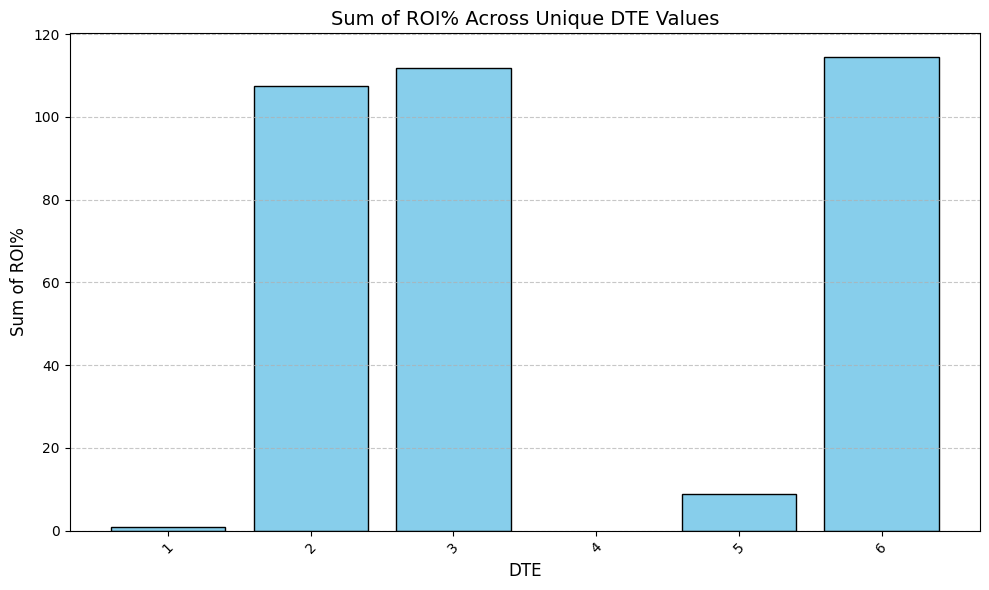

In [316]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sum_roi_by_dte(tb):
    """
    Plots the sum of ROI% across all unique DTE values.

    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    """
    # Ensure the DataFrame contains the required columns
    required_columns = {'DTE', 'ROI%'}
    if not required_columns.issubset(tb.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Group by DTE and calculate the sum of ROI%
    result = tb.groupby('DTE', as_index=False)['ROI%'].sum()
    result.rename(columns={'ROI%': 'Sum_ROI%'}, inplace=True)

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(result['DTE'], result['Sum_ROI%'], color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.title('Sum of ROI% Across Unique DTE Values', fontsize=14)
    plt.xlabel('DTE', fontsize=12)
    plt.ylabel('Sum of ROI%', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# tb = pd.DataFrame({'DTE': [...], 'ROI%': [...]})  # Replace with your actual DataFrame
plot_sum_roi_by_dte(tb)


/tmp/ipykernel_42796/3694656327.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dd_result = tb.groupby('DTE').apply(calculate_max_dd).reset_index()



Resulting DataFrame:
   DTE  Sum_ROI%  Max_DD%  ROI/DD_Ratio
0    1   18.4600  19.8300        0.9300
1    2  121.5900  24.1200        5.0400
2    3  111.2100  23.3100        4.7700
3    5   15.9700  10.0800        1.5800
4    6  266.2900  32.0400        8.3100


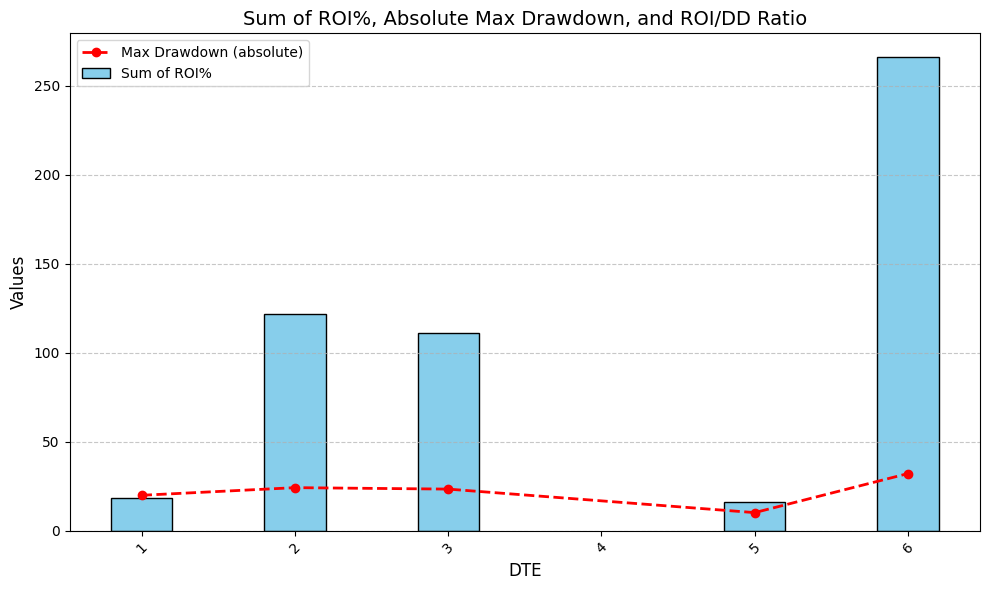

In [284]:
def plot_sum_roi_and_max_dd_by_dte(tb):
    """
    Plots the sum of ROI% and Absolute Max Drawdown (Max DD) across all unique DTE values
    using a single Y-axis, and prints the resulting DataFrame.

    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    """
    # Ensure the DataFrame contains the required columns
    required_columns = {'DTE', 'ROI%'}
    if not required_columns.issubset(tb.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Group by DTE and calculate the sum of ROI%
    roi_result = tb.groupby('DTE', as_index=False)['ROI%'].sum()
    roi_result.rename(columns={'ROI%': 'Sum_ROI%'}, inplace=True)

    # Group by DTE and calculate Max DD (in absolute terms)
    dd_result = tb.groupby('DTE').apply(calculate_max_dd).reset_index()
    dd_result.rename(columns={0: 'Max_DD%'}, inplace=True)
    dd_result['Max_DD%'] = dd_result['Max_DD%'].abs()

    # Merge the sum of ROI% and Max DD data
    result = pd.merge(roi_result, dd_result, on='DTE')

    # Add ROI% / Max DD ratio
    result['ROI/DD_Ratio'] = result.apply(
        lambda row: row['Sum_ROI%'] / row['Max_DD%'] if row['Max_DD%'] != 0 else float('inf'), axis=1
    )

    # Format values
    result['Sum_ROI%'] = result['Sum_ROI%'].round(2)
    result['Max_DD%'] = result['Max_DD%'].round(2)
    result['ROI/DD_Ratio'] = result['ROI/DD_Ratio'].round(2)

    # Print the DataFrame
    print("\nResulting DataFrame:")
    print(result)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Sum of ROI%
    ax.bar(result['DTE'], result['Sum_ROI%'], color='skyblue', edgecolor='black', label='Sum of ROI%', width=0.4, align='center')
    
    # Overlay Max DD (absolute values) on the same axis
    ax.plot(result['DTE'], result['Max_DD%'], color='red', marker='o', label='Max Drawdown (absolute)', linestyle='--', linewidth=2)

    ax.set_xlabel('DTE', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    # Title, legend, and grid
    plt.title('Sum of ROI%, Absolute Max Drawdown, and ROI/DD Ratio', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    fig.tight_layout()
    plt.show()

plot_sum_roi_and_max_dd_by_dte(tb)
